# NEURAL STYLE TRANSFER ON IMAGE WITH BACKGROUND RETAINED
## INTRODUCTION-
The project aims at transferring a style image on the face of a person while retaining the background as it is.The person's image(content_image)+ abstract image(style_image)= face of person stylized(new_stylized image).
The issue with running a simple neural model for this problem is that the background isn't retained as it is.So the solution to this is given the foreground extraction and segmentation also known as foreground-background extraction.
## MODEL-
The first part is running the neural style transfer model on the content and style image to give the stylized image without the background retained.
The next part is extraction of background from the content image and foreground form the stylized_image adding both the of them together to give the stylized_image with background retained as it is.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub

In [2]:
import numpy as np
import PIL
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch
from PIL import Image
from torchvision import models

In [3]:
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files

In [4]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [5]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

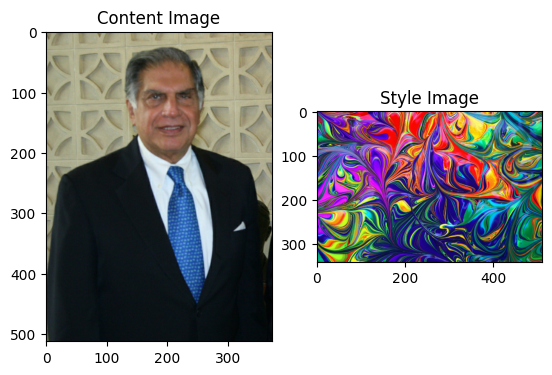

In [6]:
content_image = load_img("/content/drive/MyDrive/Neural_style_transfer/Ratan_Tata_photo.jpg")
style_image = load_img("/content/drive/MyDrive/Neural_style_transfer/style 2.jpeg")

plt.subplot(1,2,1)
imshow(content_image, 'Content Image')

plt.subplot(1,2,2)
imshow(style_image, 'Style Image')

In [7]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')  #loading pretained model from tensorflow
                                                                                                #for stylized image generation
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

In [8]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype = np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

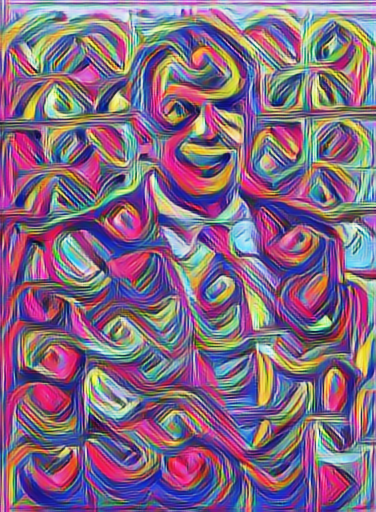

In [9]:
tensor_to_image(stylized_image)

In [10]:
import torch
torch.cuda.empty_cache()

In [11]:
tensor_to_image(stylized_image).save(fp="flashy.jpg")

# Training Model on Own

In [12]:
import torchvision

In [13]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 [==============================] - 27s 0us/step


TensorShape([1, 1000])

In [14]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 0us/step


[('suit', 0.7895707),
 ('Windsor_tie', 0.13144398),
 ('bow_tie', 0.025189152),
 ('groom', 0.014666494),
 ('Loafer', 0.004405371)]

In [15]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 5s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [16]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [17]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.inputs], outputs)
  return model

In [18]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
  print(name)
  print(" shape: ", output.numpy().shape)
  print(" min: ", output.numpy().min())
  print(" max: ", output.numpy().max())
  print(" mean: ", output.numpy().mean())

block1_conv1
 shape:  (1, 341, 512, 64)
 min:  0.0
 max:  726.0589
 mean:  38.99086
block2_conv1
 shape:  (1, 170, 256, 128)
 min:  0.0
 max:  5861.055
 mean:  224.12978
block3_conv1
 shape:  (1, 85, 128, 256)
 min:  0.0
 max:  11404.024
 mean:  330.829
block4_conv1
 shape:  (1, 42, 64, 512)
 min:  0.0
 max:  26913.143
 mean:  1016.769
block5_conv1
 shape:  (1, 21, 32, 512)
 min:  0.0
 max:  4027.8254
 mean:  84.56626


In [19]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [20]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [21]:

extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0052463575
    max:  30683.604
    mean:  400.15594

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  47014.426
    mean:  9655.588

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  158393.44
    mean:  8977.341

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2473341.2
    mean:  130530.555

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  85836.95
    mean:  1103.6041

Contents:
   block5_conv2
    shape:  (1, 32, 23, 512)
    min:  0.0
    max:  1333.3695
    mean:  12.523203


In [22]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [23]:
image = tf.Variable(content_image)

In [24]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max =1.0)

In [25]:
opt = tf.optimizers.Adam(learning_rate = 0.02, beta_1=0.99, epsilon = 1e-1)

In [26]:
style_weight=1e-4
content_weight=1e4

In [27]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [28]:

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [29]:

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

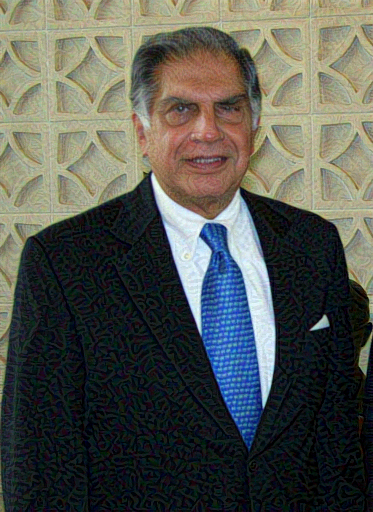

In [30]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [31]:
import time
start = time.time()

epochs = 7
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  # display.clear_output(wait=True)
  # display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

....................................................................................................Train step: 100
....................................................................................................Train step: 200
....................................................................................................Train step: 300
....................................................................................................Train step: 400
....................................................................................................Train step: 500
....................................................................................................Train step: 600
....................................................................................................Train step: 700
Total time: 47.8


In [32]:
tensor_to_image(image).save(fp="flashy.jpg")

In [33]:


#Define the helper function

def decode_segmap(image, nc=21):
  label_colors = np.array([(255, 255, 255),  # 0=background
                           # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                           (128, 0, 0), (0, 128, 0), (255, 255, 255), (0, 0, 128), (128, 0, 128),
                           # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                           (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
                           # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
                           (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (0, 0, 0),
                           # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
                           (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])  #setting the pixel values for the segmented
#image . Not required to set the values for all the labels. Here pixel values for background are set to (0,0,0) and person (255,255,255).
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
  return rgb



In [34]:
def segment(net, path, show_orig=True,dev='cuda'):
  img = Image.open(path)
  if show_orig:
   plt.imshow(img);
   plt.axis('off');
   plt.show()
# The preprocessing of image is done and converted to a tensor and then normalized.The normalizing part can be commented.
  trf = T.Compose([T.ToTensor(),
  T.Normalize(mean = [0.485, 0.456, 0.406],
  std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  return rgb

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 122MB/s] 


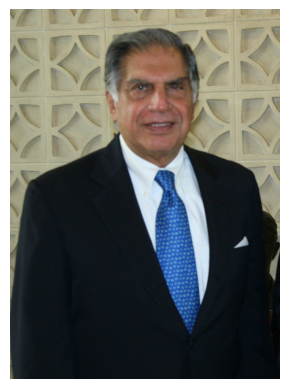

In [35]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()
rgb=segment(dlab, "/content/drive/MyDrive/Neural_style_transfer/Ratan_Tata_photo.jpg")

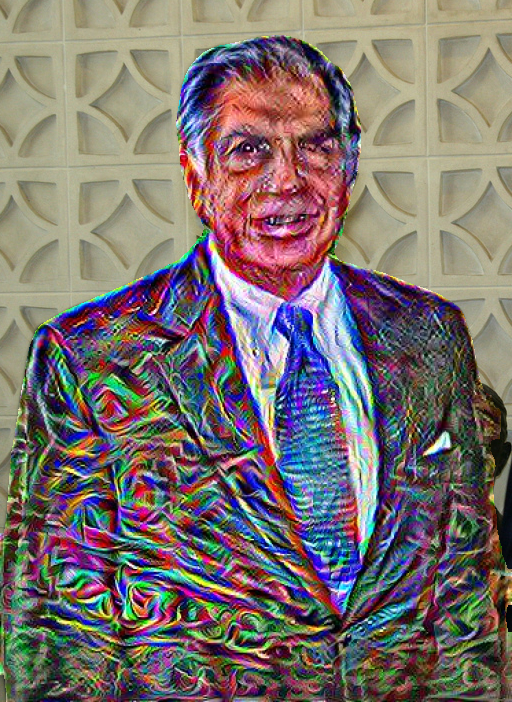

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:


#alpha blending to customize the background of the image
# Read the images
foreground = cv2.imread("/content/drive/MyDrive/Neural_style_transfer/Ratan_Tata_photo.jpg")
background = cv2.imread("/content/flashy.jpg", cv2.IMREAD_COLOR)
background = cv2.resize(background, (rgb.shape[1],rgb.shape[0]), interpolation = cv2.INTER_AREA)
alpha = rgb  #maximum pixel values for background and 0 for person's image.
# Convert uint8 to float
foreground = foreground.astype(float)
background = background.astype(float)
# Normalize the alpha mask to keep intensity between 0 and 1
alpha = alpha.astype(float)/255  #after multiplication intensity values should be between (0,255)
# Multiply the foreground with the alpha matte
foreground = cv2.multiply(alpha, foreground)
# Multiply the background with ( 1 - alpha )
background = cv2.multiply(1.0 - alpha, background)
# Add the masked foreground and background.
outImage = cv2.add(foreground, background) #adding the images together.
# Display image
cv2_imshow(outImage)
cv2.waitKey(0)
# Save/download image
cv2.imwrite('org_plus_cust_bkg_img.png' , outImage)
files.download('org_plus_cust_bkg_img.png') #downloads the image files.

